<a href="https://colab.research.google.com/github/moajez/natural-language-processing-nlp-projects/blob/main/speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [6]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

In [7]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2024-04-01 14:09:18--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  88.5MB/s    in 22s     

2024-04-01 14:09:40 (120 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [8]:
!mkdir "/content/dataset/"

In [9]:
!tar -xjvf "/content/LJSpeech-1.1.tar.bz2" -C "/content/dataset/"

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [10]:
audio_binary=tf.io.read_file("/content/dataset/LJSpeech-1.1/wavs/LJ001-0030.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(152477,)


(152477,)


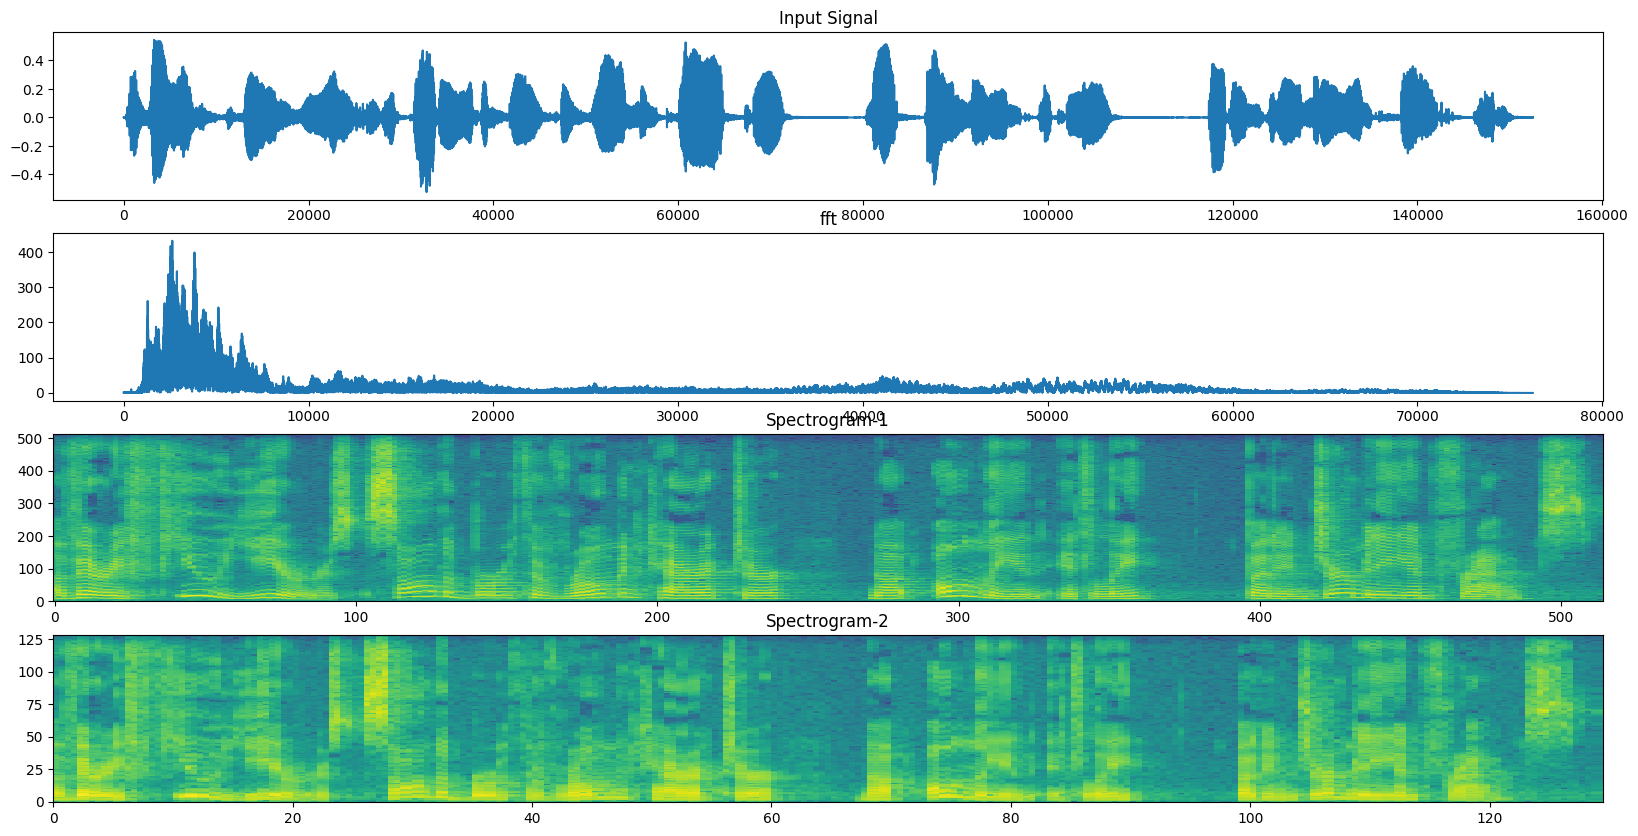

In [11]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()

#data Preparation

In [12]:
audio_text={}

In [13]:
csv_path="/content/dataset/LJSpeech-1.1/metadata.csv"
with open(csv_path,encoding="utf-8")as f:
  for line in f:
    i=line.strip().split("|")[0]
    text=line.strip().split("|")[1]
    audio_text[str(i)]=text

In [14]:
filepaths=["/content/dataset/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text.keys())]
transcriptions=[audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [15]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

In [16]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [17]:
def decode_audio(audio_binary):
  audio,_=tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio,axis=-1)

In [18]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [19]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [20]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [21]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [22]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [23]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[7.12798326e-04]
   [4.62571252e-03]
   [6.20642118e-03]
   ...
   [1.35252893e-04]
   [7.60609837e-05]
   [3.36043013e-05]]

  [[4.23590001e-03]
   [7.16409134e-03]
   [3.25928186e-03]
   ...
   [9.35658172e-05]
   [5.88824805e-05]
   [2.21005175e-05]]

  [[3.52023495e-03]
   [1.79913230e-02]
   [2.51728315e-02]
   ...
   [3.46498855e-04]
   [1.54141060e-04]
   [1.43282465e-04]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[5.27175982e-03]
   [8.09575524e-03]
   [1.60869583e-02]
   ...
   [1.84489501e-04]
   [1.14731905e-04]
   [1.01984711e-04]]

  [[5.57353161e-03]
   [1.64909065e-02]
   [1.31872818e-01]
   ...
   [1.4453

In [24]:
normalization=tf.keras.layers.Normalization

In [26]:
import tensorflow as tf

Os = tf.keras.layers.Normalization()  # Assuming this is the intended normalization layer

input_spectrogram = tf.keras.Input(shape=(None, 129, 1), name="input")

x = Os(input_spectrogram)
x = tf.keras.layers.Conv2D(32, kernel_size=[11, 41], strides=[2, 2], padding='same', activation='relu')(x)

x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Conv2D(64, kernel_size=[11, 21], strides=[1, 2], padding='same', activation='relu')(x)

x = tf.keras.layers.LayerNormalization()(x)

x = tf.keras.layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)

output = tf.keras.layers.Dense(len(vocabulary) + 1, activation="softmax")(x)

model = tf.keras.Model(inputs=input_spectrogram, outputs=output, name="DeepSpeech_2_Inspired")
model.summary()


Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization_1 (Normaliza  (None, None, 129, 1)      3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (Layer  (None, None, 65, 32)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Lay  (None, None, 33,

In [27]:
tf.__version__

'2.15.0'

In [28]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [29]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR)
)

In [56]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    verbose=1,
    epochs=N_EPOCHS
)

Epoch 1/100
 72/389 [====>.........................] - ETA: 24:43 - loss: 310.5543

KeyboardInterrupt: 

#testing

In [46]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [47]:
test_path="/content/dataset/LJSpeech-1.1/wavs/LJ001-0158.wav"

In [48]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

(1386, 129, 1)
1/1 [==============================] - 0s 104ms/step


In [49]:
out

<tf.Tensor: shape=(693,), dtype=int64, numpy=
array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,

In [50]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)

In [51]:
print(out_str)

[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LIN

In [52]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [54]:
print(decode(tf.expand_dims(out,axis=0)))

tf.Tensor([  1 693], shape=(2,), dtype=int32)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
